In [2]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

### Load model

In [3]:
name = "underdamped_k12"

overdamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
overdamped_name = f"model_{name}.pth"
overdamped_model, training_log = model.load_model(overdamped_path, overdamped_name)

12 True True True 1.0 16 [128, 128, 256]


### Problem definition

In [4]:
N = 5120
t_span = (0, 8)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [5]:
H_dict = transfer.compute_H_dict(overdamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [6]:
w_list_transfer = [1, 1, 1]
zeta_list = [0.25, 0.4, 0.7]

def forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.cos(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.cos(t)), axis=1)
    return force

forcing_list = [forcing(True), forcing(True), forcing(True), forcing(True), forcing(True)]

forcing_1D = lambda t: np.cos(t)
ic_list = [[0.5, 0], [0.5, 0], [0.5, 0]]
epsilon_list = [0.5, 0.5, 0.5]
p_list = [6]
q = 3

### Numerical solver

In [7]:
numerical_list = []

for zeta in zeta_list:
    ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta, forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
    numerical_list.append(numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0]))

### PINN

In [8]:
NN_TL_solution, perturbation_solution, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution = NN_TL_solution.squeeze()

In [9]:
NN_TL_solution.shape

(5120, 3, 2)

In [10]:
PINN_solution = []

for perturbation_zeta in perturbation_solution:

    perturbation = []
    for perturbation_order in perturbation_zeta:

        perturbation.append(perturbation_order[:, 0])

    PINN_solution.append(standard.calculate_general_series(perturbation, epsilon_list[0]))

zeta: 0.25, order: 0, mean error absolute: 0.26888476221257196
zeta: 0.25, order: 1, mean error absolute: 0.22140165025444877
zeta: 0.25, order: 2, mean error absolute: 0.24320380972089964
zeta: 0.25, order: 3, mean error absolute: 0.2303314693001383
zeta: 0.25, order: 4, mean error absolute: 0.22197863621941805
zeta: 0.25, order: 5, mean error absolute: 0.256702159107247


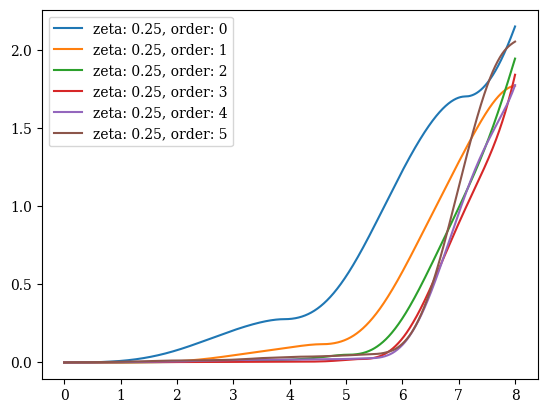

zeta: 0.4, order: 0, mean error absolute: 0.1377975009088297
zeta: 0.4, order: 1, mean error absolute: 0.06987848055138852
zeta: 0.4, order: 2, mean error absolute: 0.035775501808532895
zeta: 0.4, order: 3, mean error absolute: 0.01603650958692087
zeta: 0.4, order: 4, mean error absolute: 0.0072068944959752645
zeta: 0.4, order: 5, mean error absolute: 0.0040523675398216105


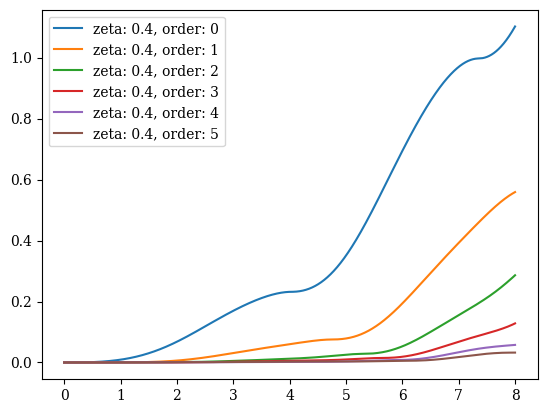

zeta: 0.7, order: 0, mean error absolute: 0.048801363928483436
zeta: 0.7, order: 1, mean error absolute: 0.009723916347271083
zeta: 0.7, order: 2, mean error absolute: 0.001866444755383174
zeta: 0.7, order: 3, mean error absolute: 0.000833316888452502
zeta: 0.7, order: 4, mean error absolute: 0.0003769152606187756
zeta: 0.7, order: 5, mean error absolute: 0.0002454190631677773


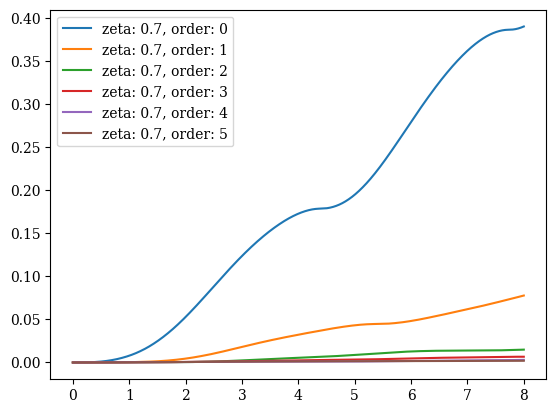

In [11]:
standard.plot_error_by_order(t_eval, PINN_solution, numerical_list, p_list, zeta_list, "zeta")

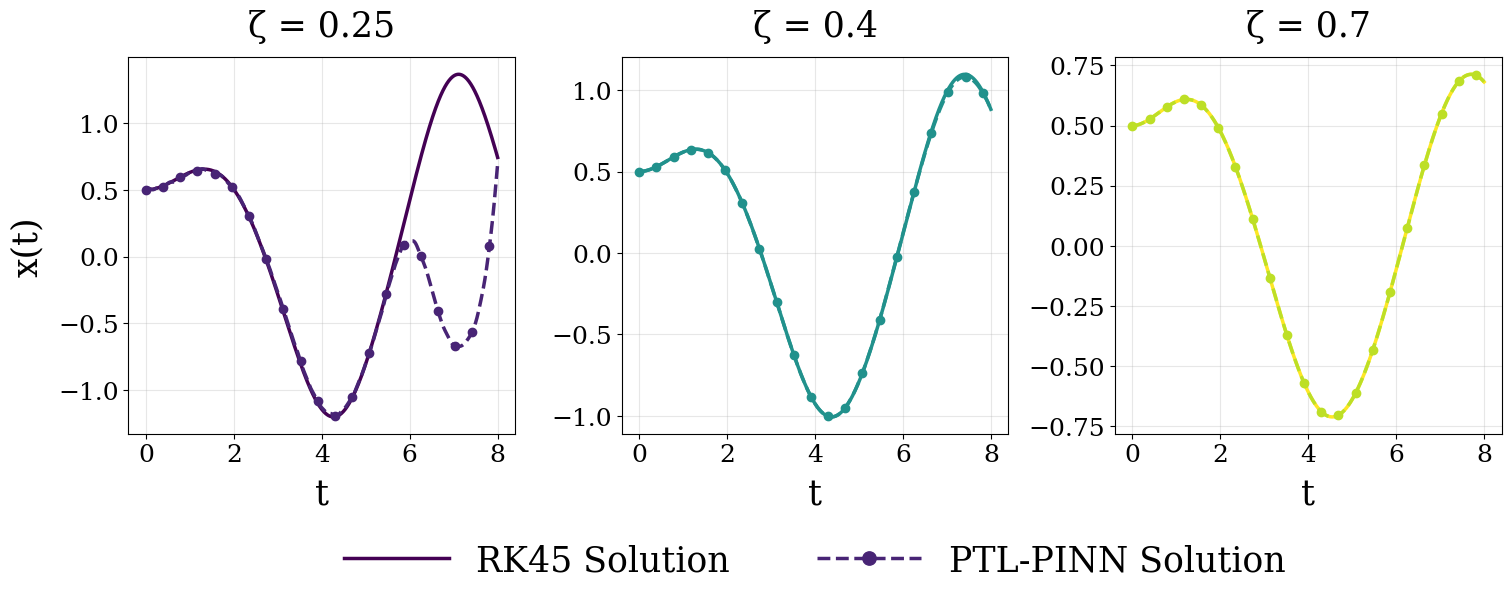

In [12]:
standard.plot_compare_multiple_zeta(t_eval, zeta_list, numerical_list, NN_TL_solution)


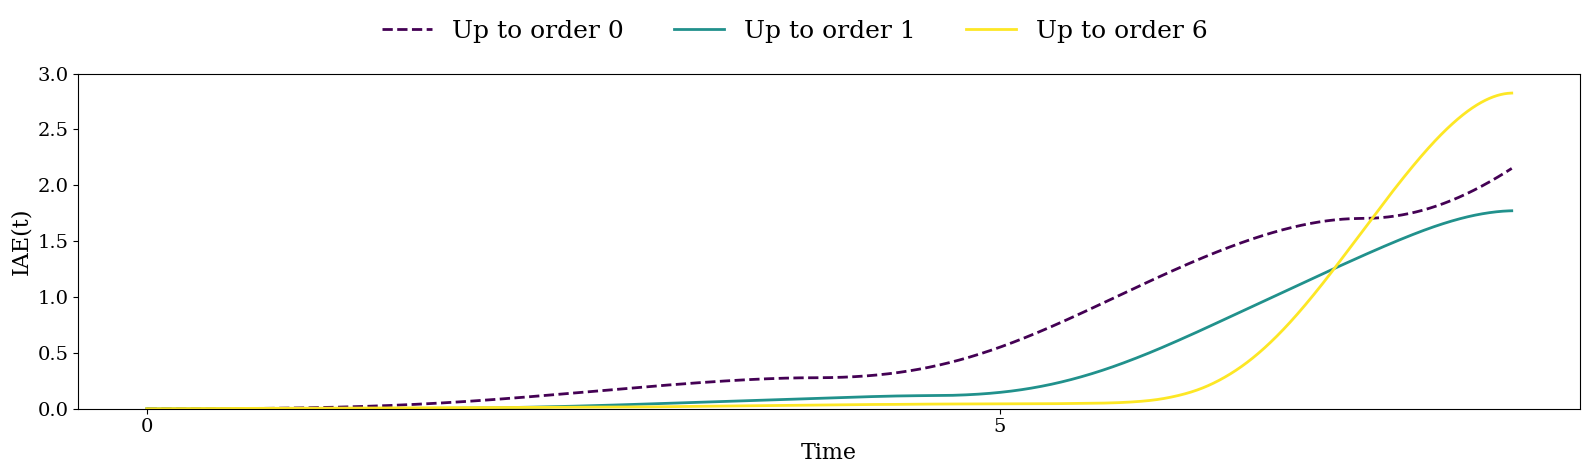

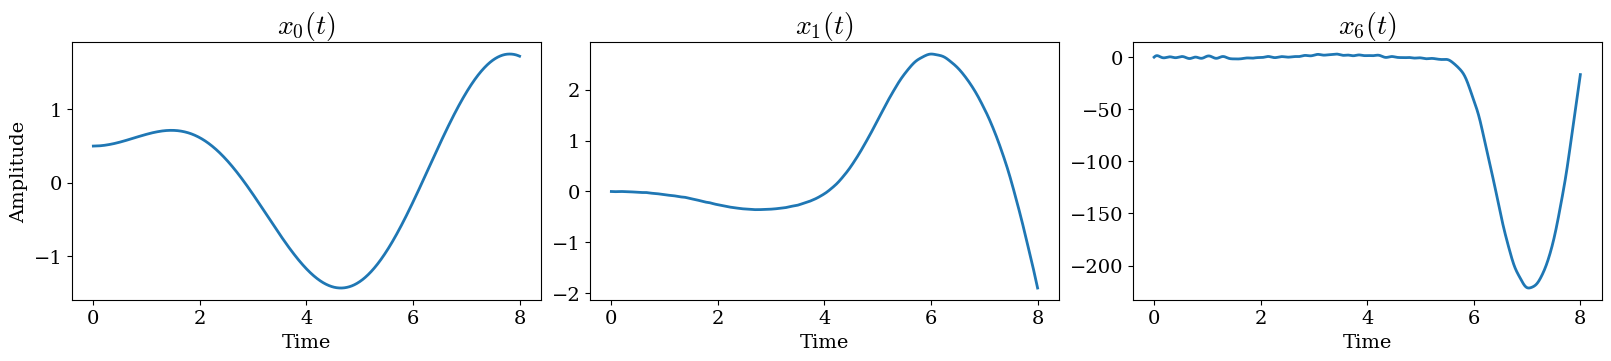

In [13]:
perturbation_solution_show = perturbation_solution[0]

PINN_x_solution = [perturbation_solution_show[i][:, 0] for i in range(len(perturbation_solution_show))]
PINN_x_solution = standard.calculate_general_series(PINN_x_solution, epsilon=epsilon_list[0])

standard.plot_IAE_and_subplots(PINN_x_solution, numerical_list[0], perturbation_solution_show, t_eval, selected_orders=[0, 1, 6], ylim=(0, 3))